In [29]:
import math
import operator
import numpy as np
import matplotlib.pyplot as plt

from scipy.special import comb
from itertools import product
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import GridSearchCV

# Majority Voting Classifiers

Technique where multiple classifiers are combined to make predictions based on the 
majority of votes. The idea is that the combined classifier is more robust than the
individual classifiers.

In [3]:
# Ensemble is the technique of combining multiple models to produce a single model.
# The idea is that multiple models working together will perform better than any single model
# by reducing the total error. The following code calculates the error rate for an ensemble
# containing 11 classifiers with an error rate of 0.25.
def ensemble_error(n_classifier, error):
    # Gets the minimum number of classifiers that need to agree on the prediction to obtain
    # a majority number of votes.
    k_start = int(math.ceil(n_classifier / 2.))
    probs = [comb(n_classifier, k) *
             error ** k *
             (1 - error) ** (n_classifier - k)
             for k in range(k_start, n_classifier + 1)]
    return sum(probs)


ensemble_error(n_classifier=11, error=0.25)

0.03432750701904297

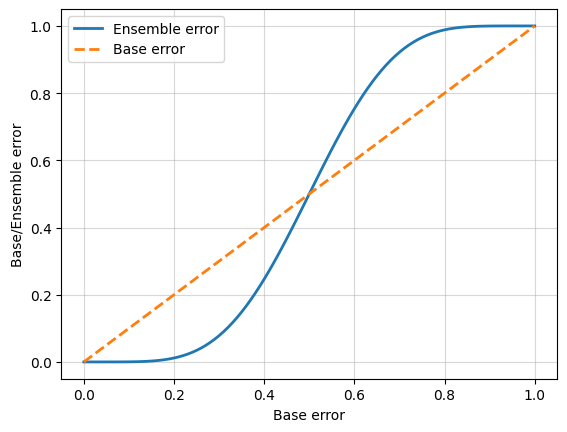

In [6]:
# Analyzing the relationship between ensemble and base error rates.
# This plot depicts that the ensemble error rate is better than the base error as long as
# the classifiers estimate better than random guessing (error < 0.5).
error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error)
              for error in error_range]
plt.plot(error_range, ens_errors, label='Ensemble error', linewidth=2)
plt.plot(error_range, error_range, linestyle='--', label='Base error', linewidth=2)
plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.show()

In [14]:
# Weighted majority vote algorithm gives to each classifier a different weight based
# on its accuracy.

# Simple example, suppose 3 classifiers where the first 2 predicts 0 and the last predicts 1.
# Also suppose the last classifier confidence is higher than the first 2, so we weight it as 0.6.
# The following function can be used to select the prediction with higher weight in this schema.
print(np.argmax(np.bincount([0, 0, 1], weights=[0.2, 0.2, 0.6])))

# If instead of using rounded prediction (0 or 1) we use the probabilities of each class from
# each classifier, then the following schema applies.
ex = np.array([[0.9, 0.1],  # Classifier 1, probas for class 0 and 1
               [0.8, 0.2],  # Classifier 2, probas for class 0 and 1
               [0.4, 0.6]])  # Classifier 3, probas for class 0 and 1
p = np.average(ex, axis=0, weights=[0.2, 0.2, 0.6])  # Weighted average of the probabilities
print(p)
print(np.argmax(p))

1
[0.58 0.42]
0


In [18]:
# A more formal implementation
# Extend these classes to get automatically get_params, set_params, and score methods.
class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError(f'Vote must be "probability" or "classlabel"')
        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Number of classifiers and weights must be equal')
        # Use LabelEncode to ensure class labels start with 0, which is important for np.argmax
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote
            # Collect results from clf.predict calls
            predictions = np.asarray([
                clf.predict(X) for clf in self.classifiers_
            ]).T

            maj_vote = np.apply_along_axis(
                lambda x: np.argmax(np.bincount(x, weights=self.weights)),
                axis=1, arr=predictions)

        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_probas = np.average(probas, axis=0, weights=self.weights)
        return avg_probas

    def get_params(self, deep=True):
        if not deep:
            return super().get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out[f'{name}__{key}'] = value
            return out

In [22]:
# Testing the MajorityVoteClassifier
# Select only two features (to make prediction harder) and only two classes.
iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1, stratify=y)

clf1 = LogisticRegression(penalty='l2', C=0.001, solver='lbfgs', random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')

# Decision trees are scale invariant so they don't need a pipeline with a StandardScaler.
pipe1 = Pipeline([
    ['sc', StandardScaler()],
    ['clf', clf1]
])
pipe3 = Pipeline([
    ['sc', StandardScaler()],
    ['clf', clf3]
])

clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN']
print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print(f'ROC AUC: {scores.mean():.2f} (+/- {scores.std():.2f}) [{label}]')
# Train 3 different classifiers

10-fold cross validation:

ROC AUC: 0.92 (+/- 0.15) [Logistic Regression]
ROC AUC: 0.87 (+/- 0.18) [Decision Tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]


In [23]:
# Using the classifiers with the MajorityVoteClassifier
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
clf_labels += ['Majority Voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print(f'ROC AUC: {scores.mean():.2f} (+/- {scores.std():.2f}) [{label}]')

# Notice on the output how the voting classifier achieves better performance
# by ensemble the three classifiers than any of the individual classifiers.

ROC AUC: 0.92 (+/- 0.15) [Logistic Regression]
ROC AUC: 0.87 (+/- 0.18) [Decision Tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]
ROC AUC: 0.98 (+/- 0.05) [Majority Voting]


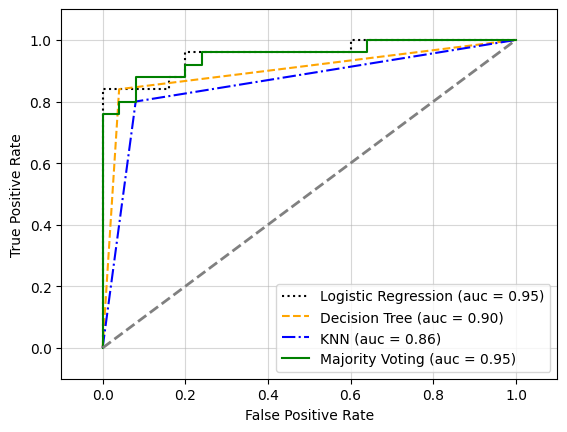

In [26]:
# Using test dataset to evaluate the final performance of the best classifier (voting classifier).
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls \
        in zip(all_clf, clf_labels, colors, linestyles):
    # assuming the label of the positive class is 1
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label=f'{label} (auc = {roc_auc:.2f})')

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()
# MajorityVoteClassifier performs relatively well on unseen data.

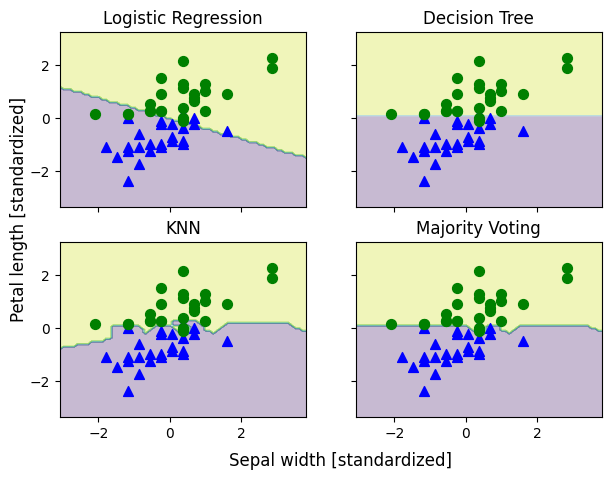

In [28]:
# Plotting the decision boundary for each classifier.
# The dataset is scaled to facilitate the visualization.
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

# Create meshgrid for the decision boundary
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row', figsize=(7, 5))
for idx, clf, tt in zip(product([0, 1], [0, 1]), all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train == 0, 0],
                                  X_train_std[y_train == 0, 1],
                                  c='blue', marker='^', s=50)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train == 1, 0],
                                  X_train_std[y_train == 1, 1],
                                  c='green', marker='o', s=50)
    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -5., s='Sepal width [standardized]', ha='center', va='center', fontsize=12)
plt.text(-12.5, 4.5, s='Petal length [standardized]', ha='center', va='center', fontsize=12, rotation=90)
plt.show()

In [31]:
# Tuning the hyperparameters of the individual classifiers.
params = {'decisiontreeclassifier__max_depth': [1, 2],
          'pipeline-1__clf__C': [0.001, 0.1, 100.0]}
grid = GridSearchCV(estimator=mv_clf, param_grid=params, cv=10, scoring='roc_auc')
grid.fit(X_train, y_train)

# Print the different hyperparameters and their corresponding scores.
for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    mean_score = grid.cv_results_['mean_test_score'][r]
    std_score = grid.cv_results_['std_test_score'][r]
    params = grid.cv_results_['params'][r]
    print(f'{mean_score:.3f} +/- {std_score:.3f} {params}')

print(f'Best parameters: {grid.best_params_}')
print(f'ROC AUC: {grid.best_score_:.2f}')

0.983 +/- 0.050 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.050 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.100 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.983 +/- 0.050 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.050 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.100 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}
Best parameters: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
ROC AUC: 0.98
